In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,decomposition
from tqdm import tqdm

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


__CUDNN VERSION: 8500
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 3060 Ti
__CUDA Device Total Memory [GB]: 8.589279232
Running on the GPU


In [476]:
data = pd.read_csv('X_data_20_0_0.csv')
data = data.drop(['0','1'],axis=1)
data = data.iloc[250:]
X = data
pca = decomposition.PCA(n_components=8, svd_solver='full')
X = pd.DataFrame(pca.fit_transform(X))
labels = pd.read_csv('y_data_20_0_0.csv')
y = (labels['team1_pts']>labels['team2_pts']).astype(int)
y = y.iloc[250:]
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.4,shuffle=False)
#X_valid, X_test, y_valid, y_test = train_test_split( X_valid, y_valid, test_size=0.5,shuffle=False)
WIDTH = len(X.columns.values)

In [477]:
from numpy import dtype
import math
from matplotlib import pyplot as plt
from sklearn import metrics

x_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

x_train_torch = torch.from_numpy(x_train_np).float()
y_train_torch = torch.from_numpy(y_train_np).float()
x_train_torch = x_train_torch.to(device)
y_train_torch = y_train_torch.to(device)

x_valid_np = X_valid.to_numpy()
y_valid_np = y_valid.to_numpy()

x_valid_torch = torch.from_numpy(x_valid_np).float()
y_valid_torch = torch.from_numpy(y_valid_np).float()

x_valid_torch = x_valid_torch.to(device)
y_valid_torch = y_valid_torch.to(device)

def out_of_sample_error():

    predicted = []
    actual = []

    with torch.no_grad():
        for idx,data in enumerate(x_valid_torch):
            output = model(data.view(-1,WIDTH))

            predicted += [output.item()]
            actual += [y_valid_torch[idx].item()]
            
    return metrics.mean_absolute_error(actual, predicted)

def in_sample_error():

    predicted = []
    actual = []

    with torch.no_grad():
        for idx,data in enumerate(x_train_torch):
            output = model(data.view(-1,WIDTH))

            predicted += [output.item()]
            actual += [y_train_torch[idx].item()]

    return metrics.mean_absolute_error(actual, predicted)

def plot_out_of_sample_error():
    predicted = []
    actual = []

    with torch.no_grad():
        for idx,data in enumerate(x_valid_torch):
            output = model(data.view(-1,WIDTH))

            predicted += [output.item()]
            actual += [y_valid_torch[idx].item()]
    plt.scatter(predicted,actual)

def plot_in_sample_error():
    predicted = []
    actual = []

    with torch.no_grad():
        for idx,data in enumerate(x_train_torch):
            output = model(data.view(-1,WIDTH))

            predicted += [output.item()]
            actual += [y_train_torch[idx].item()]
    plt.scatter(predicted,actual)

In [481]:
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. The Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# The Flatten layer flatens the output of the linear layer to a 1D tensor,
# to match the shape of `y`.
from torch import sigmoid


model = torch.nn.Sequential(
    torch.nn.Linear(WIDTH, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
    torch.nn.Sigmoid(),
    torch.nn.Flatten(0, 1)
)
model.to(device)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

learning_rate = 1e-3
numPasses = 400
for t in range(numPasses):

    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x_train_torch)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y_train_torch)
    if t % 100 == 99:
        print(t, loss.item(), round(in_sample_error(),3), round(out_of_sample_error(),3))
        pass

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

99 6334.6591796875 0.369 0.423
199 6299.74169921875 0.307 0.429
299 6283.8095703125 0.277 0.419
399 6288.84326171875 0.264 0.392


(array([618.,  47.,  34.,  59.,  29.,  33.,  23.,  34.,  60., 787.]),
 array([2.4938456e-15, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

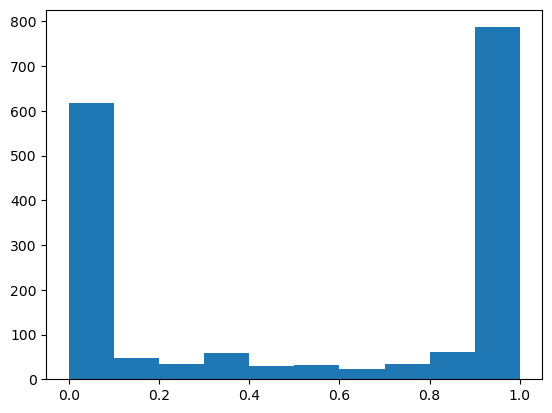

In [482]:
plt.hist(y_pred.cpu().detach().numpy())

In [483]:
correct = 0
total = 0

with torch.no_grad():
    for idx,data in tqdm(enumerate(x_train_torch)):
        output = model(data.view(-1,WIDTH))

        if round(output.item()) == y_train_torch[idx].item():
            correct = correct + 1
        total = total + 1

print("Train Accuracy: ", round(correct/total, 3))

correct = 0
total = 0

with torch.no_grad():
    for idx,data in tqdm(enumerate(x_valid_torch)):
        output = model(data.view(-1,WIDTH))

        if round(output.item()) == y_valid_torch[idx].item():
            correct = correct + 1
        total = total + 1

print("Valid Accuracy: ", round(correct/total, 3))

1724it [00:00, 1770.97it/s]


Train Accuracy:  0.742


1150it [00:00, 2417.35it/s]

Valid Accuracy:  0.56


In [416]:
sum(y_valid.values)/len(y_valid.values)

0.49478260869565216

In [484]:
conf_thresh = .3

with torch.no_grad():
    for idx,data in tqdm(enumerate(x_train_torch)):
        output = model(data.view(-1,WIDTH))
        if abs(output.item()-.5) > conf_thresh:
            if round(output.item()) == y_train_torch[idx].item():
                correct = correct + 1
            total = total + 1

print("Train Accuracy: ", round(correct/total, 3))

correct = 0
total = 0

with torch.no_grad():
    for idx,data in tqdm(enumerate(x_valid_torch)):
        output = model(data.view(-1,WIDTH))
        if abs(output.item()-.5) > conf_thresh:
            if round(output.item()) == y_valid_torch[idx].item():
                correct = correct + 1
            total = total + 1

print("Valid Accuracy: ", round(correct/total, 3))

1724it [00:01, 1663.69it/s]


Train Accuracy:  0.673


1150it [00:00, 2377.48it/s]

Valid Accuracy:  0.574
